In [1]:
import os


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.model_selection import train_test_split


def split_into_chunks(l, n):
    """ split list into chunks with each of it being < n long. 
    source: https://www.geeksforgeeks.org/break-list-chunks-size-n-python """
    return [l[i * n:(i + 1) * n] for i in range((len(l) + n - 1) // n)]


class Dataset:
    def __init__(self, name, path, labels_files_names, is_dummy=False):
        self.name = name
        self.path = path
        label_files_paths = self.get_labels_files_paths(path, labels_files_names)

        self.schema = [
            'projectname', 'packageandclass', 'path',
            'readability', 'understandability', 'complexity',
            'modularization', 'overall'
        ]

        self.dimensions = ['readability', 'understandability', 'complexity', 'modularization', 'overall']
        self.dimensions_original = list(map(lambda d: d + '_original', self.dimensions))

        self.dimensions_highest_probability_class = \
            list(map(lambda d: d + ' (highest probability class)', self.dimensions))

        self.dimensions_highest_probability_class_simplified = \
            list(map(lambda d: d + ' (highest probability class simplified)', self.dimensions))

        self.dimensions_classes_expectation_value = \
            list(map(lambda d: d + ' (class expectation value)', self.dimensions))

        # class indices from 0 to 3:
        self.classes = ['strongly agree', 'weakly agree', 'weakly disagree', 'strongly disagree']
        # class indices implified (binary):
        self.classes_simplified = ['agree', 'disagree']

        # read labels files
        column_indices = [self.schema.index(col) for col in ['path', *self.dimensions]]
        self.dataframe = self.read_labels_file(label_files_paths.pop(0), column_indices)
        while len(label_files_paths) > 0:
            further_dataframe = self.read_labels_file(label_files_paths.pop(0), column_indices)
            self.dataframe = self.dataframe.append(further_dataframe, ignore_index=True)

        # change dimension column names to dimensionname_original
        self.dataframe = self.dataframe.rename(columns=dict(zip(self.dimensions, self.dimensions_original)))

        # read code from file path as string
        self.dataframe['code'] = self.dataframe['path'].apply(self.read_code_file)

        self.set_class_interpretations()

    def get_labels_files_paths(self, path, labels_files_names):
        return [os.path.join(path, label_file_name) for label_file_name in labels_files_names]

    def read_labels_file(self, file_path, chosen_column_indices):
        return pd.read_csv(file_path, sep=',', usecols=chosen_column_indices)

    def read_code_file(self, file_path):
        file_path = os.path.join(self.path, *file_path.split('\\'))
        file_content = open(file_path, 'r', encoding='ISO-8859-1').read()
        return file_content

    def set_class_interpretations(self):
        for i in range(len(self.dimensions)):
            # Take the argmax of the Likert scale ratings, thus resulting in 4 possible discrete classes 
            # (strongly agree, weakly agree, weakly disagree, strongly disagree) => the dataset is very imbalanced
            self.dataframe[self.dimensions_highest_probability_class[i]] = \
                self.dataframe[self.dimensions_original[i]].apply(self.get_index_highest_prob_class)

            # Binary approach to cope with imbalance: the 3 least represented classes are merged into 1 class, 
            # such that the result are 2 discrete classes (agree, disagree) that are roughly balanced
            self.dataframe[self.dimensions_highest_probability_class_simplified[i]] = \
                self.dataframe[self.dimensions_highest_probability_class[i]].apply(
                    lambda c: self.get_index_highest_prob_class_simplified(c, self.dimensions[i]))

            # Calculate the expectation value of the given probabilites for the Likert scale ratings
            self.dataframe[self.dimensions_classes_expectation_value[i]] = \
                self.dataframe[self.dimensions_original[i]].apply(self.get_class_expectation_value)

    def get_index_highest_prob_class(self, class_probabilities_string):
        # calculate the index of the class with the highest probability
        probabilities = self.parse_class_probabilities(class_probabilities_string)
        index = np.argmax(probabilities)
        return index

    def get_index_highest_prob_class_simplified(self, class_index, dimension):
        # similar to get_index_highest_prob_class; this time merging the 3 least popular classes into 1 class;
        # for complexity, the first 3 classes are the minority, for the other dimensions the last 3 classes
        agree_indices = [0, 1, 2] if dimension == 'complexity' else [0]
        # based on self.classes_simplified
        binary_class = 0 if class_index in agree_indices else 1
        return binary_class

    def get_class_expectation_value(self, class_probabilities_string):
        # calculate the expectation value of the classes
        indices = range(1, len(self.classes) + 1)
        probabilities = self.parse_class_probabilities(class_probabilities_string)
        expected_value = reduce(lambda acc, t: acc + t[0] * t[1], zip(indices, probabilities), 0)
        return expected_value

    def parse_class_probabilities(self, class_probabilities_string):
        # class_probabilities_string looks like this: {4.38897e-007,0.848266,0.151734,3.13027e-008}
        number_strings = class_probabilities_string.replace('{', '').replace('}', '').split(',')
        probabilities = list(map(float, number_strings))
        return probabilities

    def shuffle(self, SEED=42):
        self.dataframe = self.dataframe.sample(frac=1, random_state=SEED).reset_index(drop=True)

    def stratify_split(self, frac_training, frac_validation, frac_test, stratify_col_name):
        """ adapted from https://stackoverflow.com/a/65571687 """

        x = self.dataframe  # Contains all columns
        y = self.dataframe[[stratify_col_name]]  # Dataframe of just the column on which to stratify

        # Split original dataframe into train and temp dataframes
        df_training, df_temp, y_train, y_temp = \
            train_test_split(x, y, stratify=y, test_size=(1.0 - frac_training), random_state=None)

        if frac_validation == 0.0:
            return df_training, df_temp
        else:
            # Split the temp dataframe into val and test dataframes
            relative_frac_test = frac_test / (frac_validation + frac_test)
            df_validation, df_test, y_val, y_test = \
                train_test_split(df_temp, y_temp, stratify=y_temp, test_size=relative_frac_test, random_state=None)

            return df_training, df_validation, df_test

    def bert_tokenize(self, tokenizer, target_column_name):
        # if already tokenized, don't do it again
        if target_column_name in self.dataframe.columns:
            return

        print('bert tokenization...')

        # work in another dataframe as a workaround to use object data type
        encoding_temp = pd.DataFrame(columns=[target_column_name])
        encoding_temp[target_column_name] = encoding_temp[target_column_name].astype(object)
        # input is limited to 512 tokens, therefore we split up each code into chunks 
        # and keep track of all chunks including the other information in a new dataframe
        dataframe_extended = pd.DataFrame().reindex_like(self.dataframe)
        dataframe_extended_current_length = 0
        for index, row in self.dataframe.iterrows():
            tokens = tokenizer.tokenize(row['code'])
            tokens_chunks = split_into_chunks(tokens, 506)  # leave space for special chars
            for tokens in tokens_chunks:
                correctly_sized_string = tokenizer.convert_tokens_to_string(tokens)
                encoding = tokenizer.encode_plus(correctly_sized_string, padding='max_length')
                dataframe_extended.loc[dataframe_extended_current_length] = row
                encoding_temp.loc[dataframe_extended_current_length, target_column_name] = np.array(encoding.input_ids)
                dataframe_extended_current_length += 1
        dataframe_extended[target_column_name] = encoding_temp[target_column_name]

        # somehow it appends ".0" to the old floats, which we need to revert:
        for dimension in self.dimensions_highest_probability_class + self.dimensions_highest_probability_class_simplified:
            dataframe_extended[dimension] = dataframe_extended[dimension].astype(int)

        self.dataframe = dataframe_extended

        print(self.dataframe)

    def print_statistics(self, show_scatter_plot=False):
        # dataframe
        print(self.dataframe)

        # number of times each class occurs per dimension
        for dimension in self.dimensions_highest_probability_class + self.dimensions_highest_probability_class_simplified:
            print(self.dataframe[dimension].value_counts(), '\n')

        # scatter plot for regression variant
        if show_scatter_plot:
            mpl.rcParams['figure.dpi'] = 300
            plt.figure(figsize=(4, 10))
            plt.xticks(range(len(self.dimensions)), self.dimensions)
            plt.yticks(range(len(self.classes)), self.classes)
            plt.gca().invert_yaxis()
            for index, dimension in enumerate(self.dimensions_classes_expectation_value):
                values = self.dataframe[dimension]
                plt.plot(np.zeros_like(values) + index, values, '_')
            plt.show()


def print_section(string):
    print('==========================\n', string, '\n==========================')


# dataset setups
dataset_path = "/mnt/c/Data/Apps/hackathon/hackjakarta/playground/dataset"
datasets = [Dataset('open source dataset', dataset_path, ['labels.csv'])]

In [3]:

# iterate over dataset setups (open source parts, all parts)
for dataset in datasets:
    print_section('dataset: ' + dataset.name)
    dataset.shuffle()
    dataset.print_statistics()

    # iterate over dataset interpretations (Likert scale and binary)
    for dimensions, classes in [
        (dataset.dimensions_highest_probability_class, dataset.classes),
        (dataset.dimensions_highest_probability_class_simplified, dataset.classes_simplified)]:

        # iterate over dimensions
        for dimension in dimensions:
            print_section('dimension: ' + dimension)
            print(dataset.dataframe[dimension].value_counts(), '\n')

 dataset: open source dataset 
                                                  path  \
0    jsweet\sourcefiles\core-lib\es6\src\main\java\...   
1    diarymanagement\sourcefiles\tbaclient\src\TBA\...   
2    argoUML\sourcefiles\src\argouml-app\src\org\ar...   
3    junit4\sourcefiles\src\main\java\org\junit\exp...   
4    aoi\sourcefiles\Translators\src\artofillusion\...   
..                                                 ...   
299  jsweet\sourcefiles\core-lib\es6\src\main\java\...   
300   aoi\sourcefiles\HelpPlugin\src\ChatTextPane.java   
301  argoUML\sourcefiles\src\argouml-app\src\org\ar...   
302  junit4\sourcefiles\src\main\java\org\junit\int...   
303  argoUML\sourcefiles\src\argouml-app\src\org\ar...   

                              readability_original  \
0      {0.971194,0.0288058,3.07528e-007,8.37e-018}   
1                             {1,1.04008e-011,0,0}   
2       {0.029332,0.954998,0.0156261,4.43023e-005}   
3    {0.788656,0.211336,7.75132e-006,1.19846e-011}   
4 

In [4]:
dataset = datasets[0]

In [5]:
dataset.dataframe[dataset.dimensions_classes_expectation_value].describe()

,readability (class expectation value),understandability (class expectation value),complexity (class expectation value),modularization (class expectation value),overall (class expectation value)
count,304.000000,304.000000,304.000000,304.000000,304.000000
mean,1.574479,1.806059,3.286172,3.314164,1.755370
std,0.715332,0.909919,0.920122,0.947128,0.955734
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.042815,1.052075,2.926884,2.992522,1.016285
50%,1.099956,1.355439,3.900417,3.888660,1.117790
75%,2.002161,2.255207,3.950188,3.960932,2.153418
max,3.999755,4.000000,4.000001,4.000001,4.000000


In [29]:
from pydantic.v1 import BaseModel, Field


class CodeScoring(BaseModel):
    """
    Score code in based on the following statements: 
    Readability - this code is easy to read; 
    Understandability - the semantic meaning of this code is clear; 
    Complexity - this code is complex; 
    Modularity  - this code should be broken into smaller pieces; 
    Overall maintainability - overall, this code is maintainable. 
    The score scale from -1000000 (strongly agree) to 1000000 (strongly disagree).
    You must score in precision, i.e. 14952, -475.456, 757850, 584.58495, 3.141598, etc.
    """
    readability: float = Field(description="Readability score.")
    understandability: float = Field(description="Understandability score.")
    complexity: float = Field(description="Complexity score.")
    modularization: float = Field(description="Modularity score.")
    overall_maintainability: float = Field(description="Overall maintainability score.")


In [40]:
from langchain_core.runnables import RunnableParallel
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage
from typing import TypedDict
from langgraph.graph import StateGraph, MessagesState
from langchain_core.output_parsers import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate, \
    AIMessagePromptTemplate

chat = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=OPENAI_API_KEY
)

tools = [CodeScoring]
parser = PydanticToolsParser(tools=tools)


class State(TypedDict):
    code: str
    analysis: str
    score: CodeScoring


def node_analyze(state: State):
    prompt = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template("""
    You are target group of our study. The target group of our study are software quality analysts, researchers with a background in software quality, and software engineers that are involved with maintaining software. Some participants have up to 15 years of experience in quality assessments. In sum, 70 professionals participated. First, we invited selected experts to participate in the study. Second, we asked them to disseminate the study to interested and qualified colleagues. The survey was also promoted in relevant net- works. The participants are affiliated with companies including Airbus, Audi, BMW, Boston Consulting Group, Celonis, cesdo Software Quality GmbH, CQSE GmbH, Facebook, fortiss, itestra GmbH, Kinexon GmbH, MaibornWolff GmbH, Munich Re, Oracle, and three universities. However, 7 participants did not want to share their affiliation. During the study, we followed a systematic approach to assess software maintainability. The following steps were taken:
    """),
        HumanMessagePromptTemplate.from_template("""
    Analyze readability, understandability, complexity, modularity, and overall maintainability metrics of the following code.
    You must use step by step comprehensive reasoning to explain your analysis.
    <code>
    {code}
    </code>
    """),
    ])
    chain = prompt | chat
    response = chain.invoke({
        "code": state["code"],
    })
    state["analysis"] = response.content
    return state


def node_score(state: State):
    prompt = ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template("""
        You are target group of our study. The target group of our study are software quality analysts, researchers with a background in software quality, and software engineers that are involved with maintaining software. Some participants have up to 15 years of experience in quality assessments. In sum, 70 professionals participated. First, we invited selected experts to participate in the study. Second, we asked them to disseminate the study to interested and qualified colleagues. The survey was also promoted in relevant networks. The participants are affiliated with companies including Airbus, Audi, BMW, Boston Consulting Group, Celonis, cesdo Software Quality GmbH, CQSE GmbH, Facebook, fortiss, itestra GmbH, Kinexon GmbH, MaibornWolff GmbH, Munich Re, Oracle, and three universities. However, 7 participants did not want to share their affiliation. During the study, we followed a systematic approach to assess software maintainability. The following steps were taken:
        """),
        HumanMessagePromptTemplate.from_template("""
        Analyze readability, understandability, complexity, modularity, and overall maintainability metrics of the following code.
        You must use step by step comprehensive reasoning to explain your analysis.
        <code>
        {code}
        </code>
        """),
        AIMessagePromptTemplate.from_template("""
        {analysis}
        """),
        HumanMessagePromptTemplate.from_template("""
        Based on your analysis and the provided code, score the code based on the following criteria:
        Readability - this code is easy to read; 
        Understandability - the semantic meaning of this code is clear; 
        Complexity - this code is complex; 
        Modularity  - this code should be broken into smaller pieces; 
        Overall maintainability - overall, this code is maintainable. 
        The score scale from -1000000 (strongly agree) to 1000000 (strongly disagree).
        You must score in precision, i.e. 14952, -475.456, 757850, 584.58495, 3.141598, etc.
        """),
    ])
    chain = prompt | chat.bind_tools(tools=tools) | parser
    response = chain.invoke({
        "code": state["code"],
        "analysis": state["analysis"]
    })
    state["score"] = response
    return state


graph = StateGraph(State)
graph.set_entry_point(node_analyze.__name__)
graph.add_node(node_analyze.__name__, node_analyze)
graph.add_node(node_score.__name__, node_score)
graph.add_edge(node_analyze.__name__, node_score.__name__)
graph.set_finish_point(node_score.__name__)
compiled_graph = graph.compile()


In [32]:
response = compiled_graph.invoke({
    "code": dataset.dataframe['code'][0]
})

In [33]:
response

{'code': 'package def.dom.intl;\n@jsweet.lang.Interface\npublic abstract class ResolvedNumberFormatOptions extends def.js.Object {\n    public String locale;\n    public String numberingSystem;\n    public String style;\n    @jsweet.lang.Optional\n    public String currency;\n    @jsweet.lang.Optional\n    public String currencyDisplay;\n    public double minimumintegerDigits;\n    public double minimumFractionDigits;\n    public double maximumFractionDigits;\n    @jsweet.lang.Optional\n    public double minimumSignificantDigits;\n    @jsweet.lang.Optional\n    public double maximumSignificantDigits;\n    public Boolean useGrouping;\n}\n\n',
 'analysis': 'To analyze the provided code snippet, we will examine various aspects of readability, understandability, complexity, modularity, and overall maintainability. Here’s a step-by-step analysis:\n\n### 1. Readability\n\n**Definition**: Readability refers to how easily code can be read and understood by someone who is familiar with the prog

In [39]:
x = pd.DataFrame([response["score"][0].dict()])
x = ((x + 1000000) / 2000000) * 3 + 1
x

,readability,understandability,complexity,modularization,overall_maintainability
0,1.15,1.225,3.55,1.3,1.225


In [47]:
selected_dataset: pd.DataFrame = dataset.dataframe.loc[:10]
selected_dataset[dataset.dimensions_classes_expectation_value].describe()

,readability (class expectation value),understandability (class expectation value),complexity (class expectation value),modularization (class expectation value),overall (class expectation value)
count,11.000000,11.000000,11.000000,11.000000,11.000000
mean,1.487410,1.908151,3.438829,3.558209,1.619612
std,0.485618,0.773503,0.716716,0.512923,0.639244
min,1.000000,1.000008,1.940862,2.833463,1.000000
25%,1.058503,1.186056,3.002058,3.003235,1.017510
50%,1.211351,2.002013,3.961344,3.808855,1.560691
75%,1.993192,2.374359,3.986278,3.970216,2.000013
max,2.114131,3.239380,4.000000,3.986063,2.865769


In [42]:
from concurrent import futures

with futures.ThreadPoolExecutor() as executor:
    tasks = []
    for index, row in selected_dataset.iterrows():
        kwargs = {
            "input": {"code": row["code"]}
        }
        task = executor.submit(compiled_graph.invoke, **kwargs)
        tasks.append(task)
    responses = [task.result() for task in tasks]

In [51]:
predicted = pd.DataFrame([response["score"][0].dict() for response in responses])
predicted = predicted.rename(columns={"overall_maintainability": "overall"})
predicted = ((predicted + 1000000) / 2000000) * 3 + 1
predicted.describe()

,readability,understandability,complexity,modularization,overall
count,11.000000,11.000000,11.000000,11.000000,11.000000
mean,1.859091,1.872727,3.052273,2.670455,1.985227
std,0.364910,0.356976,0.207501,0.515366,0.312891
min,1.225000,1.225000,2.725000,1.450000,1.375000
25%,1.637500,1.675000,2.950000,2.575000,1.787500
50%,2.050000,2.050000,3.025000,2.875000,2.125000
75%,2.125000,2.087500,3.137500,2.950000,2.200000
max,2.200000,2.275000,3.550000,3.100000,2.275000


In [44]:
expected = selected_dataset[dataset.dimensions_classes_expectation_value].rename(
    columns=dict(zip(dataset.dimensions_classes_expectation_value, dataset.dimensions)))
expected

,readability,understandability,complexity,modularization,overall
0,1.028807,1.111403,3.975756,3.979663,1.013828
1,1.000000,1.000008,4.000000,3.975870,1.000001
2,1.986384,2.740079,2.591814,2.833463,2.276708
3,1.211351,1.697925,3.961344,2.838980,1.927840
4,2.114131,3.239380,1.940862,3.004811,2.865769
5,2.000000,2.844343,3.000000,3.001660,2.000000
6,1.088199,1.260710,3.984427,3.964561,1.149678
7,1.830838,2.008639,3.004115,3.808855,1.560691
8,1.099956,1.077158,3.988128,3.946899,1.021191
9,2.001849,2.008008,3.380674,3.986063,2.000025


In [49]:
from rexmex import RatingMetricSet, ScoreCard, ClassificationMetricSet


def evaluate_classification(y_true, y_pred):
    metric_set = ClassificationMetricSet()
    score_card = ScoreCard(metric_set)
    report = score_card.get_performance_metrics(y_true, y_pred)
    print(report)


def evaluate_regression(y_true, y_pred):
    metric_set = RatingMetricSet()
    score_card = ScoreCard(metric_set)
    report = score_card.get_performance_metrics(y_true, y_pred)
    print(report)





In [ ]:
for dimension in dataset.dimensions:
    print(f'Evaluation for dimension: {dimension}')
    evaluate_classification(expected[dimension], predicted[dimension])

In [56]:
for dimension in dataset.dimensions:
    print(f'Evaluation for dimension: {dimension}')
    evaluate_regression(expected[dimension], predicted[dimension])

Evaluation for dimension: readability
       mae       mse      rmse     mape      smape  r_squared  \
0  0.62211  0.566435  0.752619  0.52289  39.199617  -1.642127   

   pearson_correlation  
0            -0.288176  
Evaluation for dimension: understandability
        mae       mse      rmse      mape      smape  r_squared  \
0  0.829816  0.795043  0.891652  0.511766  45.199515  -0.461704   

   pearson_correlation  
0            -0.266962  
Evaluation for dimension: complexity
        mae       mse      rmse      mape      smape  r_squared  \
0  0.680615  0.586261  0.765677  0.205652  21.071402  -0.255423   

   pearson_correlation  
0             0.256251  
Evaluation for dimension: modularization
        mae      mse      rmse      mape      smape  r_squared  \
0  0.908943  1.26288  1.123779  0.241379  29.731535  -4.280195   

   pearson_correlation  
0             0.012188  
Evaluation for dimension: overall
        mae      mse     rmse      mape      smape  r_squared  \
0  0.68

<Axes: xlabel='expected', ylabel='predicted'>

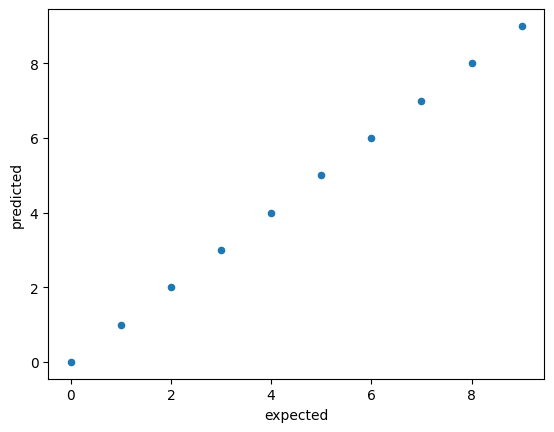

In [59]:
plot = pd.DataFrame({
    "expected": [i for i in range(10)],
    "predicted": [i for i in range(10)]
})
plot.plot.scatter(x="expected", y="predicted")